## IMPACT DE L'ENERGY STAR SCORE

Le score ENERGY STAR fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment.

Nous allons évaluer si ce score à un impact significatif sur les performances de notre modélisation.

___
### 0.1 Importation des librairies Python nécessaires

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time

___
### 0.2 Importation des fonctions utiles

Par soucis de clarté (lisibilité) et afin d'assurer un meilleur confort de lecture de ce notebook, les fonctions implémentées pour la manipulation des données et la réalisation des graphiques ont été regroupées dans le fichier project_functions.py.

Ces fonctions sont importées via la ligne de code ci-dessous:

In [3]:
import project_functions as pf

___
### 0.3 Chargement du jeu de données

In [4]:
data = pd.read_csv("data_filter.csv", sep=",").iloc[:, 1:]

In [5]:
#On se restreint aux lignes aux l'energystar_score est renseigné

data = data[data['energystar_score'].isnull()==False]

### 1 Encodage et standardisation des features

Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [6]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64']) 

In [8]:
energystar_score = numerical_features['energystar_score']
numerical_features = numerical_features.drop(['energystar_score'], axis=1)

In [9]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

#### Préparation du Preprocessor

In [10]:
#TargetEncoder
target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
target_transformer = TargetEncoder()

#Standardisation
numeric_features = ['NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

### 5.1 Sans l'Energy Star Score

On utilise ici le meilleur modèle calculé sur la variable `TotalGHGEmissions` ayant exclut l'ENERGY STAR Score :

### 1.3 Préparation des jeux d'entrainement et de test

Afin de **tester notre meilleur modèle** sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test *(20% des données)*

In [11]:
Y = data_filter[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 833 lignes,
Test: 209 lignes.



In [12]:
param_rfr = {'regressor__n_estimators': [100, 200, 500, 700, 1000],
             'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25, 50],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

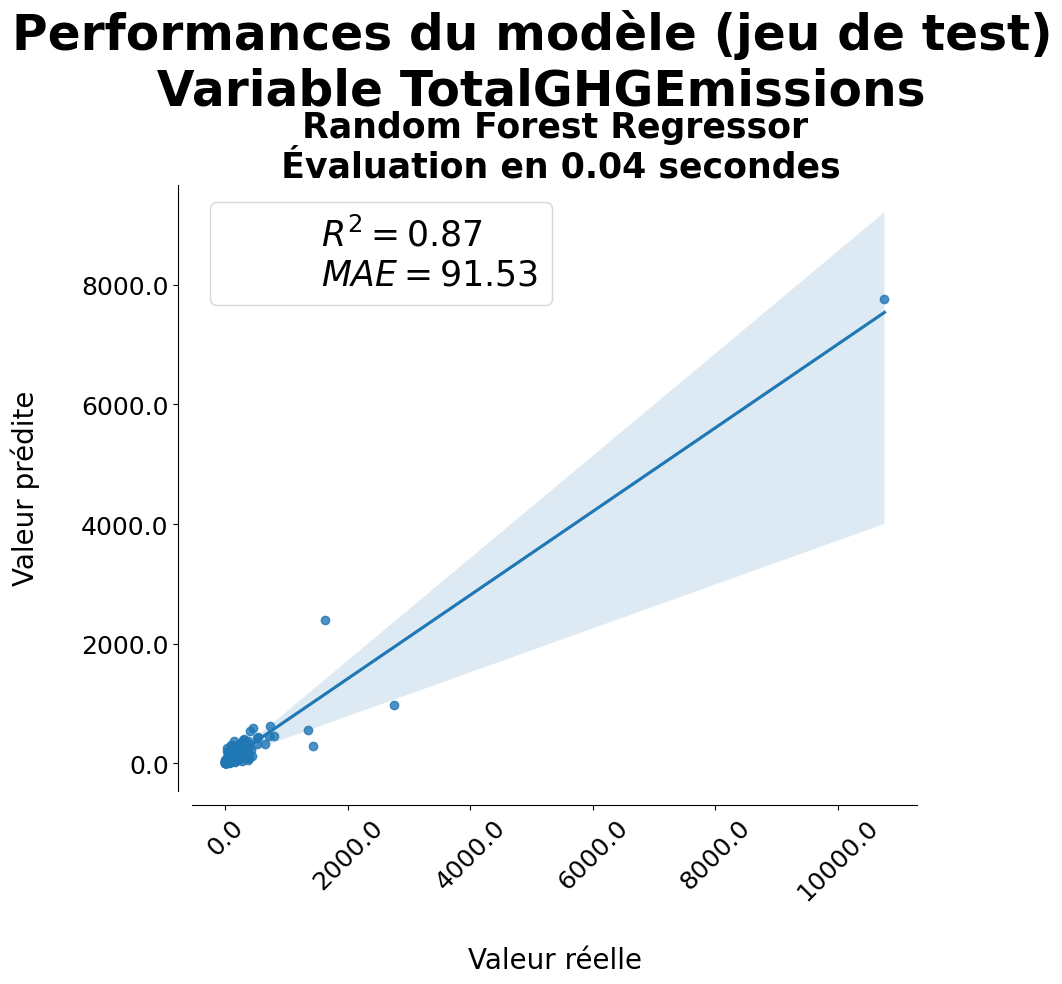

In [13]:
# Re-entrainement
GHG_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])

estimators2 = {"Random Forest Regressor" : GHG_rfr_model}

# Prédiction sur le jeu de test
r2_mae_time_GHG_Test = pf.predictPlot(estimators2, X_test,Y_test['TotalGHGEmissions'], 'TotalGHGEmissions')

In [14]:
# Récupération des métriques Train et Test

GHG_rfr_results = pf.model_scores(GHG_rfr_model, 'grid_search_rfr', X_train)
r2_mae_time_GHG_Train = pd.DataFrame()

r2_mae_time_GHG_Train.loc['Train', "MAE"] = GHG_rfr_model.named_steps['grid_search_rfr'].best_score_
r2_mae_time_GHG_Train.loc['Train', "R2"] = np.mean(GHG_rfr_results[GHG_rfr_results.rank_test_r2 == 1]['mean_test_r2'])
r2_mae_time_GHG_Train.loc['Train', "Time"] = round((np.mean(GHG_rfr_results.mean_fit_time)*X_train.shape[0]),2)

r2_mae_time_GHG_Train['MAE'] = -r2_mae_time_GHG_Train['MAE']
r2_mae_time_GHG_Train

Meilleur score MAE : -115.76
Meilleur Score R2 : 0.586
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Temps moyen d'entrainement : 1564.57s


,MAE,R2,Time
Train,115.760345,0.586016,1564.57


In [15]:
r2_mae_time_GHG_Test = r2_mae_time_GHG_Test.rename(index={'Random Forest Regressor': 'Test'})
r2_mae_time_GHG_Test

,MAE,R2,Time
Test,91.529113,0.873217,0.041888


In [16]:
r2_mae_time_GHG_Train_Test = pd.concat([r2_mae_time_GHG_Train,r2_mae_time_GHG_Test])
r2_mae_time_GHG_Train_Test

,MAE,R2,Time
Train,115.760345,0.586016,1564.570000
Test,91.529113,0.873217,0.041888


### 5.2 Avec l'Energy Star Score

In [17]:
### Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score

#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y = Y[Y.index.isin(list(X.index))]

X.shape

(1042, 14)

Regardons la distribution de cette variable ainsi que sa relation avec les émissions de CO2 :

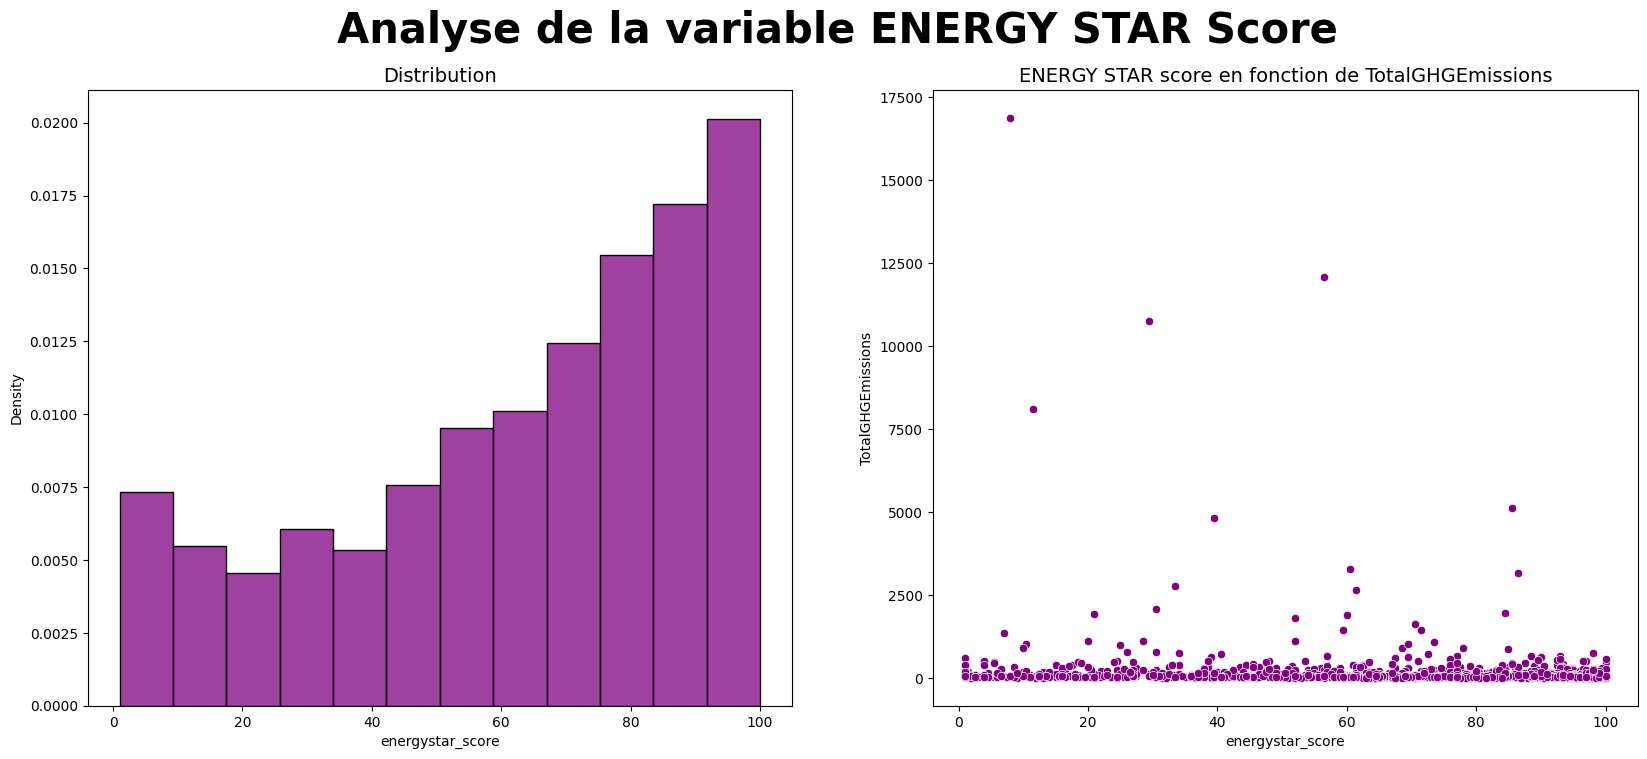

In [18]:
sns.set_palette(sns.dark_palette("purple", reverse="True"))
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", fontsize=14)
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='TotalGHGEmissions', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions",fontsize=14)
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=30, fontweight='bold')
plt.show()

On remarque ici que le score ENERGY STAR ne semble pas avoir de corrélation importante avec les émissions de CO2. La distribution ne suit pas de loi normale et la majorité des batiments a un score supérieur à 50 *(de bonne qualité voir de très bonne qualité)*.

In [19]:
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 833 lignes,
Test: 209 lignes.



On utilise ici le meilleur modèle calculé sur la variable `TotalGHGEmissions` en incluant l'ENERGY STAR Score :

In [21]:
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

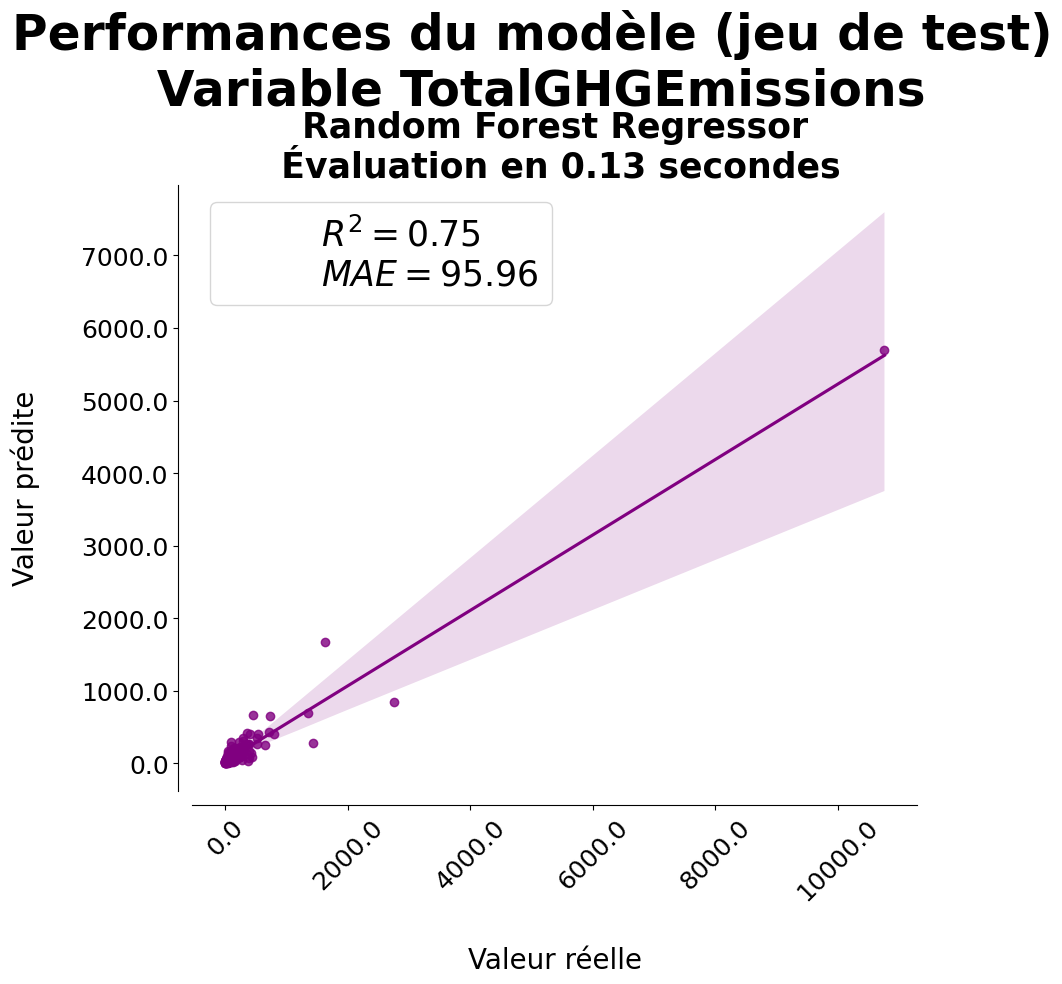

In [22]:
sns.set_palette(sns.dark_palette("purple", reverse="True"))

# Re-entrainement
GHG_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train, Y_train['TotalGHGEmissions'])

estimators = {"Random Forest Regressor" : GHG_rfr_model_eStar}

# Prédiction sur le jeu de test
r2_mae_time_GHG_eStar_Test = pf.predictPlot(estimators, X_test,Y_test['TotalGHGEmissions'], 'TotalGHGEmissions')

In [26]:
# Récupération des métriques Train et Test

GHG_rfr_results_eStar = pf.model_scores(GHG_rfr_model_eStar, 'grid_search_rfr_eStar', X_train)
r2_mae_time_GHG_eStar_Train = pd.DataFrame()

r2_mae_time_GHG_eStar_Train.loc['Train', "MAE"] = GHG_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_score_
r2_mae_time_GHG_eStar_Train.loc['Train', "R2"] = np.mean(GHG_rfr_results_eStar[GHG_rfr_results_eStar.rank_test_r2 == 1]['mean_test_r2'])
r2_mae_time_GHG_eStar_Train.loc['Train', "Time"] = round((np.mean(GHG_rfr_results_eStar.mean_fit_time)*X_train.shape[0]),2)

r2_mae_time_GHG_eStar_Train['MAE'] = -r2_mae_time_GHG_eStar_Train['MAE']
r2_mae_time_GHG_eStar_Train

Meilleur score MAE : -116.823
Meilleur Score R2 : 0.559
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
Temps moyen d'entrainement : 1594.0s


,MAE,R2,Time
Train,116.82292,0.558982,1594.0


In [27]:
r2_mae_time_GHG_eStar_Test = r2_mae_time_GHG_eStar_Test.rename(index={'Random Forest Regressor': 'Test'})
r2_mae_time_GHG_Test

,MAE,R2,Time
Test,91.529113,0.873217,0.041888


In [28]:
r2_mae_time_GHG_eStar_Train_Test = pd.concat([r2_mae_time_GHG_eStar_Train,r2_mae_time_GHG_eStar_Test])
r2_mae_time_GHG_eStar_Train_Test

,MAE,R2,Time
Train,116.822920,0.558982,1594.000000
Test,95.963966,0.746277,0.132645


**Conclusion**

L’ajout de l'ENERGY STAR score n’améliore pas forcément les performances du modèle